In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

import re

from sodapy import Socrata

### Read Data

In [2]:

import pandas as pd
from sodapy import Socrata

client = Socrata("data.texas.gov", None)

results = client.get("ubdr-4uff", limit=300000)

# Convert to pandas DataFrame
df1 = pd.DataFrame.from_records(results)

In [3]:
df = df1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259592 entries, 0 to 259591
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   complaint_number          259592 non-null  object
 1   respondent_name           259592 non-null  object
 2   complainant_role          259592 non-null  object
 3   reason                    259586 non-null  object
 4   complaint_confirmed_code  259587 non-null  object
 5   disposition               258554 non-null  object
 6   received_date             259592 non-null  object
 7   closed_date               259592 non-null  object
 8   complaint_type            259591 non-null  object
 9   coverage_type             259592 non-null  object
 10  coverage_level            259592 non-null  object
 11  respondent_id             259592 non-null  object
 12  respondent_role           259590 non-null  object
 13  respondent_type           259592 non-null  object
 14  comp

In [5]:
df.head()

,complaint_number,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,coverage_level,respondent_id,respondent_role,respondent_type,complainant_type,involved_party_type,keyword
0,1,METROPOLITAN LIFE INSURANCE COMPANY,Relative,Cust Service Claim Handling,No,Other,2012-06-12T00:00:00.000,2012-07-25T00:00:00.000,"Life, Accident and Health",Life & Annuity,Individual Life,13191,Ins Co - Licensed/Active,Organization,INDV,NaN,NaN
1,2,AETNA LIFE INSURANCE COMPANY,Provider,Delays (Claims Handling),No,Information Furnished,2012-06-21T00:00:00.000,2012-08-01T00:00:00.000,"Life, Accident and Health",Accident and Health,Group A&H,245,Ins Co - Licensed/Active,Organization,ORG,Insured,NaN
2,3,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Provider,Denial Of Claim,No,Other,2012-06-11T00:00:00.000,2012-07-30T00:00:00.000,"Life, Accident and Health",Accident and Health,Group A&H,10047,Ins Co - Licensed/Active,Organization,ORG,NaN,NaN
3,4,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Provider,Denial Of Claim,No,Other,2012-06-28T00:00:00.000,2012-07-30T00:00:00.000,"Life, Accident and Health",Accident and Health,Group A&H,10047,Ins Co - Licensed/Active,Organization,ORG,NaN,NaN
4,5,"CHARTER OAK FIRE INSURANCE COMPANY, THE",Insured,Unsatisfactory Settle/Offer,No,Question of Fact; Contract Language/Legal Issue,2012-06-13T00:00:00.000,2012-07-17T00:00:00.000,Property and Casualty,Automobile,Individual Private Pass,2918,Ins Co - Licensed/Active,Organization,INDV,NaN,2012 NORTH TEXAS TORNADOES; ADJUSTER'S HANDLIN...


In [6]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword'],
      dtype='object')

## Data Preprocessing

1) Convert to Datetime

In [7]:
df['closed_date'] = pd.to_datetime(df['closed_date'])
df['received_date'] = pd.to_datetime(df['received_date'])

2) Create 'Year', 'Month' and 'Day' columns

In [8]:
df['Open_Year']=df['received_date'].dt.year
df['Open_Month']=df['received_date'].dt.month
df['Open_Day']=df['received_date'].dt.day
df['Close_Year']=df['closed_date'].dt.year
df['Close_Month']=df['closed_date'].dt.month
df['Close_Day']=df['closed_date'].dt.day

3) Create 'Duration' column

In [9]:
df['Duration'] = (df['closed_date'] - df['received_date']).dt.days

4) Calcurate the duration of open complaints(NaN)

In [10]:
df['Duration']=df['Duration'].fillna(dt.datetime.now()-df['received_date'])

5) Create new column status which includes binary numbers.
Verdict won 'Yes' = 1 and Verdict won 'No' = 0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259592 entries, 0 to 259591
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          259592 non-null  object        
 1   respondent_name           259592 non-null  object        
 2   complainant_role          259592 non-null  object        
 3   reason                    259586 non-null  object        
 4   complaint_confirmed_code  259587 non-null  object        
 5   disposition               258554 non-null  object        
 6   received_date             259592 non-null  datetime64[ns]
 7   closed_date               259592 non-null  datetime64[ns]
 8   complaint_type            259591 non-null  object        
 9   coverage_type             259592 non-null  object        
 10  coverage_level            259592 non-null  object        
 11  respondent_id             259592 non-null  object        
 12  re

In [12]:
df.head()

,complaint_number,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,...,complainant_type,involved_party_type,keyword,Open_Year,Open_Month,Open_Day,Close_Year,Close_Month,Close_Day,Duration
0,1,METROPOLITAN LIFE INSURANCE COMPANY,Relative,Cust Service Claim Handling,No,Other,2012-06-12,2012-07-25,"Life, Accident and Health",Life & Annuity,...,INDV,NaN,NaN,2012,6,12,2012,7,25,43
1,2,AETNA LIFE INSURANCE COMPANY,Provider,Delays (Claims Handling),No,Information Furnished,2012-06-21,2012-08-01,"Life, Accident and Health",Accident and Health,...,ORG,Insured,NaN,2012,6,21,2012,8,1,41
2,3,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Provider,Denial Of Claim,No,Other,2012-06-11,2012-07-30,"Life, Accident and Health",Accident and Health,...,ORG,NaN,NaN,2012,6,11,2012,7,30,49
3,4,"BLUE CROSS AND BLUE SHIELD OF TEXAS, A DIVISIO...",Provider,Denial Of Claim,No,Other,2012-06-28,2012-07-30,"Life, Accident and Health",Accident and Health,...,ORG,NaN,NaN,2012,6,28,2012,7,30,32
4,5,"CHARTER OAK FIRE INSURANCE COMPANY, THE",Insured,Unsatisfactory Settle/Offer,No,Question of Fact; Contract Language/Legal Issue,2012-06-13,2012-07-17,Property and Casualty,Automobile,...,INDV,NaN,2012 NORTH TEXAS TORNADOES; ADJUSTER'S HANDLIN...,2012,6,13,2012,7,17,34


In [13]:
# Trim whitespace from all columns with string data
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [14]:
# Convert all columns to propercase if they are strings
df = df.apply(lambda x: x.str.title() if x.dtype == "object" else x)

In [15]:


# Define keywords for categorizing dispositions as 'verdict won' or 'verdict not won'
verdict_won_keywords = ["Claim Settled", "Additional Monies Received"]
verdict_not_won_keywords = ["No Jurisdiction", "Company Position Upheld", "Insufficient Information", "Contract Language/Legal Issue", "Question of Fact"]

# Define the categorize_verdict function
def categorize_verdict(disposition):
    if any(keyword in disposition for keyword in verdict_won_keywords):
        return "Yes"
    elif any(keyword in disposition for keyword in verdict_not_won_keywords):
        return "No"
    else:
        return "Uncategorized"

# Convert the disposition column to strings
df['disposition'] = df['disposition'].astype(str)

# Apply categorization to the disposition data
df['verdict_passed'] = df['disposition'].apply(categorize_verdict)

# Drop rows where the disposition was categorized as "Uncategorized"
df = df[df['verdict_passed'] != "Uncategorized"]

# Replace disposition column with verdict_passed column and drop verdict_passed
# df['disposition'] = df['verdict_passed']
# df = df.drop(columns=['verdict_passed'])

# Continue with the rest of your code


In [16]:
df.head()

,complaint_number,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,...,involved_party_type,keyword,Open_Year,Open_Month,Open_Day,Close_Year,Close_Month,Close_Day,Duration,verdict_passed
4,5,"Charter Oak Fire Insurance Company, The",Insured,Unsatisfactory Settle/Offer,No,Question Of Fact; Contract Language/Legal Issue,2012-06-13,2012-07-17,Property And Casualty,Automobile,...,NaN,2012 North Texas Tornadoes; Adjuster'S Handlin...,2012,6,13,2012,7,17,34,No
5,6,Reassure America Life Insurance Company,Insured,Cash Value; Misrepresentation,No,No Jurisdiction,2012-06-18,2012-07-30,"Life, Accident And Health",Life & Annuity,...,NaN,NaN,2012,6,18,2012,7,30,42,No
6,7,Usaa General Indemnity Company,Third Party,Unsatisfactory Settle/Offer,No,Question Of Fact; Claim Settled,2012-02-27,2012-07-02,Property And Casualty,Automobile,...,Insured,Claim Evaluation,2012,2,27,2012,7,2,126,Yes
7,8,"Blue Cross And Blue Shield Of Texas, A Divisio...",Insured,Denial Of Claim,No,Company Position Upheld,2012-06-19,2012-08-06,"Life, Accident And Health",Accident And Health,...,NaN,NaN,2012,6,19,2012,8,6,48,No
11,12,"Healthspring Life & Health Insurance Company, ...",Relative,Denial Of Claim,No,Contract Language/Legal Issue,2012-06-18,2012-07-19,"Life, Accident And Health",Accident And Health,...,Gr Elected Official; Insured,NaN,2012,6,18,2012,7,19,31,No


In [17]:
def close_status(a):
    if a=='Yes':
        return 1
    else:
        return 0

In [18]:
df['status'] = df['verdict_passed'].apply(close_status)

In [19]:
df.info(
)

<class 'pandas.core.frame.DataFrame'>
Index: 179921 entries, 4 to 259590
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          179921 non-null  object        
 1   respondent_name           179921 non-null  object        
 2   complainant_role          179921 non-null  object        
 3   reason                    179920 non-null  object        
 4   complaint_confirmed_code  179916 non-null  object        
 5   disposition               179921 non-null  object        
 6   received_date             179921 non-null  datetime64[ns]
 7   closed_date               179921 non-null  datetime64[ns]
 8   complaint_type            179920 non-null  object        
 9   coverage_type             179921 non-null  object        
 10  coverage_level            179921 non-null  object        
 11  respondent_id             179921 non-null  object        
 12  respond

## Visualizations

1) Bar chart by 'Conclusion' and count

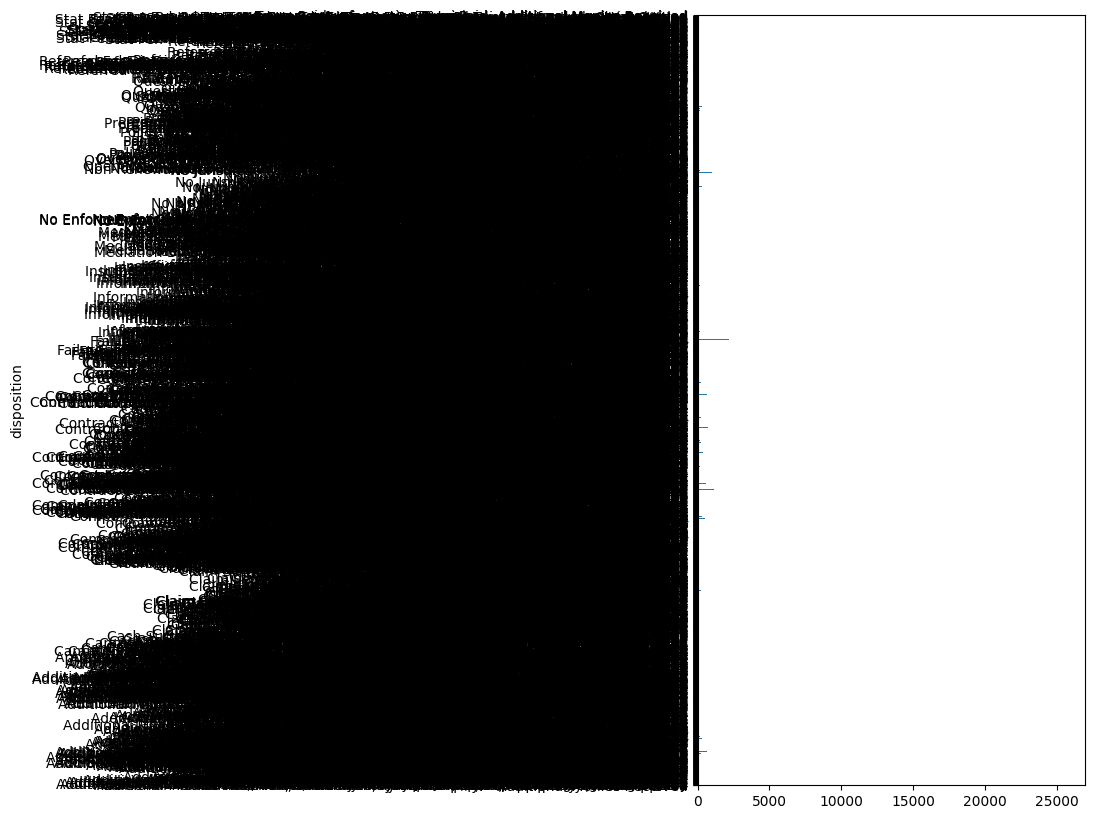

In [20]:

plt.figure(figsize=(5,10))
df.groupby('disposition')['complaint_number'].count().plot.barh();


2) Bar chart by 'Company'(Top 50) and count

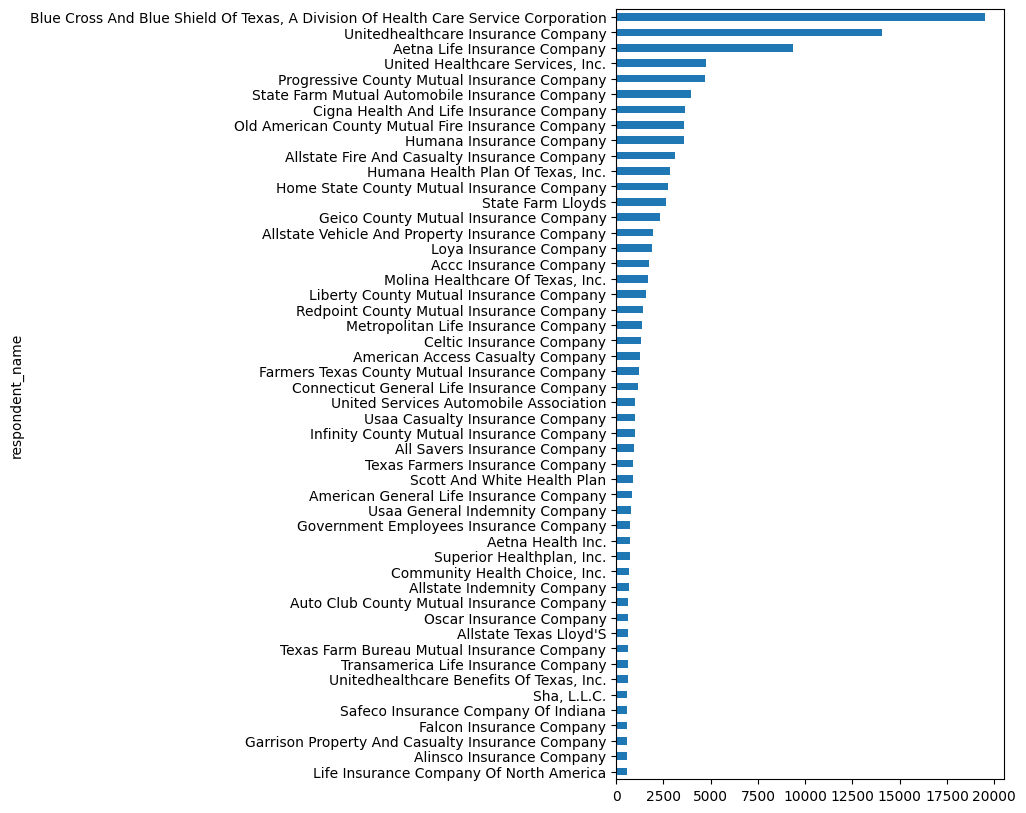

In [21]:
plt.figure(figsize=(5,10))
df.groupby('respondent_name')['complaint_number'].count().sort_values(ascending=True).tail(50).plot.barh();

In [22]:
print("There are " + str(df['respondent_name'].nunique()) + " unique companies in data")

There are 6318 unique companies in data


7) Time series by 'Opened''File No' count

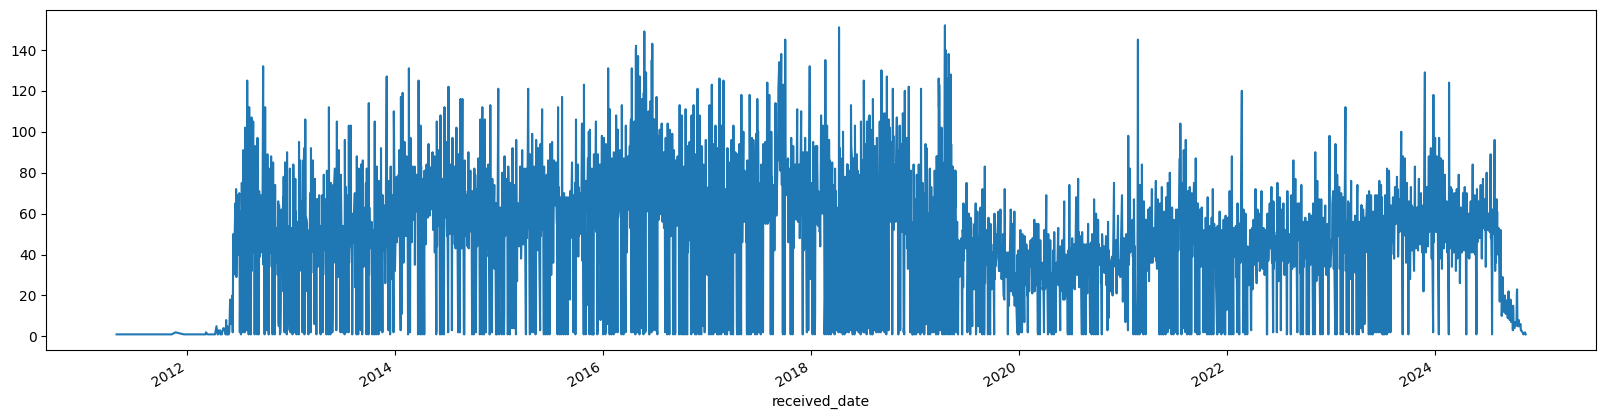

In [23]:
plt.figure(figsize=(20,5))
df.groupby('received_date')['complaint_number'].count().plot();

9) Bar plot by Top 30 'Coverage'

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179921 entries, 4 to 259590
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          179921 non-null  object        
 1   respondent_name           179921 non-null  object        
 2   complainant_role          179921 non-null  object        
 3   reason                    179920 non-null  object        
 4   complaint_confirmed_code  179916 non-null  object        
 5   disposition               179921 non-null  object        
 6   received_date             179921 non-null  datetime64[ns]
 7   closed_date               179921 non-null  datetime64[ns]
 8   complaint_type            179920 non-null  object        
 9   coverage_type             179921 non-null  object        
 10  coverage_level            179921 non-null  object        
 11  respondent_id             179921 non-null  object        
 12  respond

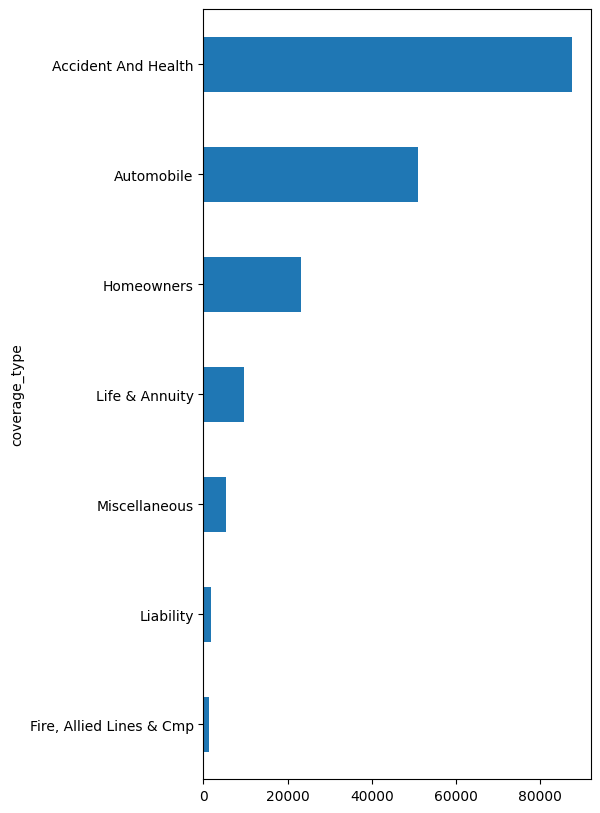

In [25]:
plt.figure(figsize=(5,10))
df.groupby('coverage_type')['complaint_number'].count().sort_values(ascending=True).tail(30).plot.barh();

In [26]:
print("There are " + str(df['coverage_type'].nunique()) + " unique coverages in data")

There are 7 unique coverages in data


10) Bar plot by 'Reason'

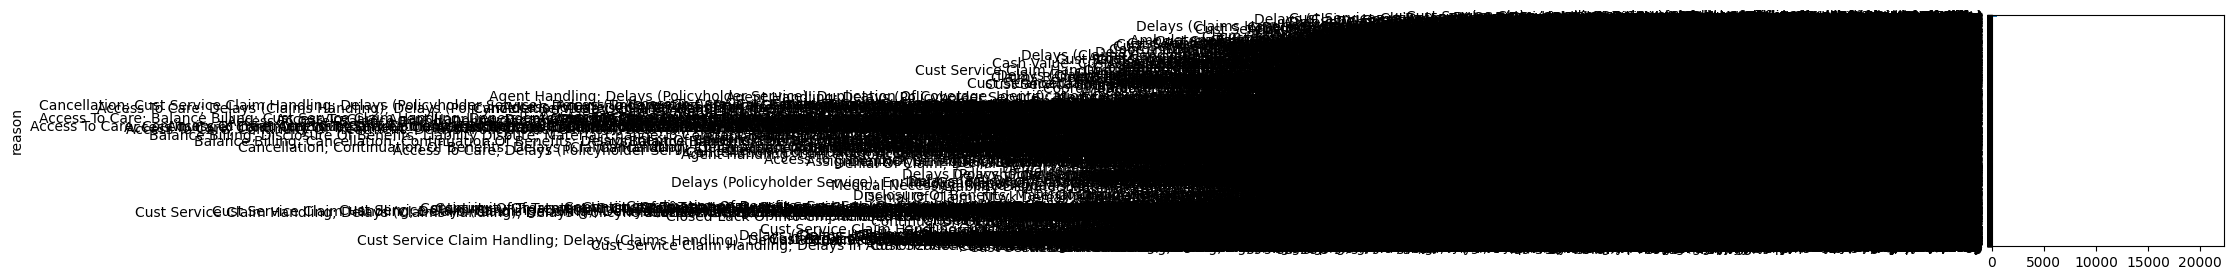

In [27]:
plt.figure(figsize=(3,3))
df.groupby('reason')['complaint_number'].count().sort_values(ascending=True).plot.barh();

11) Bar plot by 'Disposition'

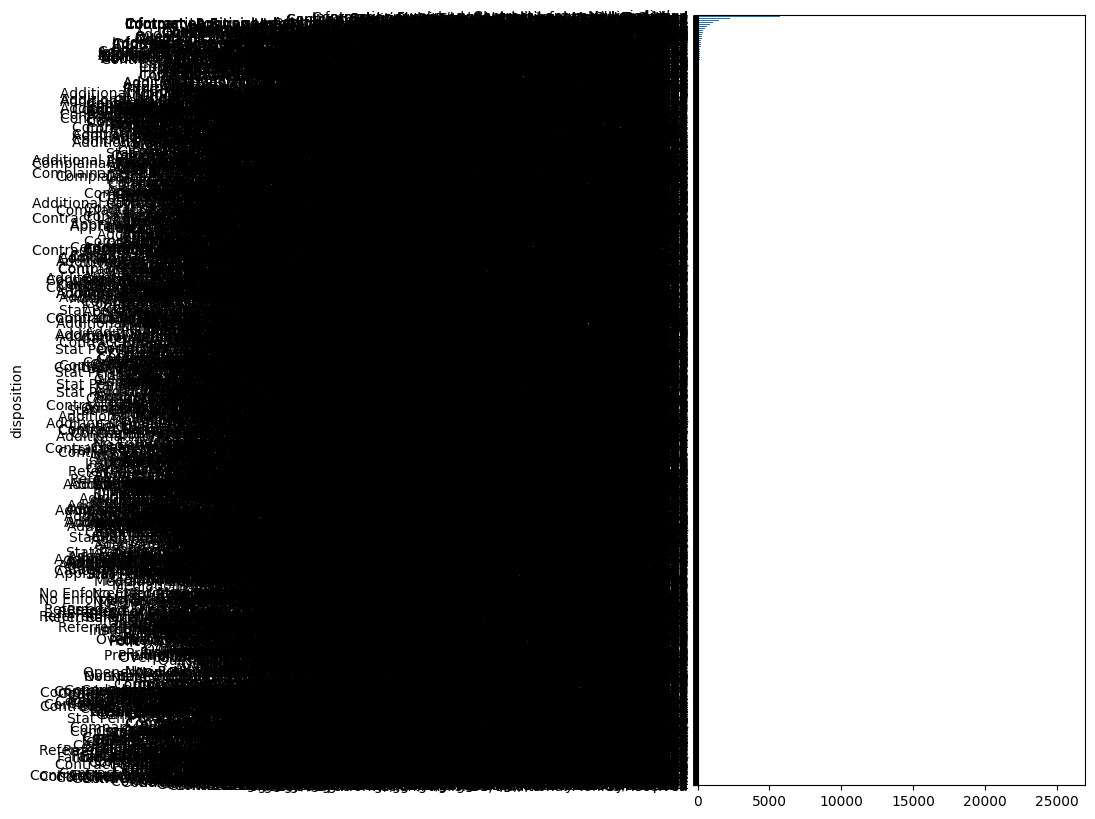

In [28]:
plt.figure(figsize=(5,10))
df.groupby('disposition')['complaint_number'].count().sort_values(ascending=True).plot.barh();

12) Bar plot by 'Conclusion'

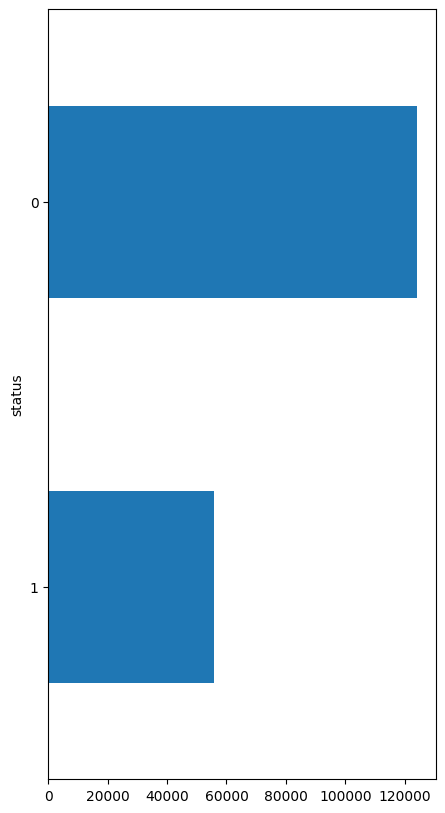

In [29]:
plt.figure(figsize=(5,10))
df.groupby('status')['complaint_number'].count().sort_values(ascending=True).plot.barh();

In [30]:
print("There are " + str(df['disposition'].nunique()) + " unique conclusions in data")

There are 2706 unique conclusions in data


14) Bar plot by 'Reason' and 'Recovery'(Log)

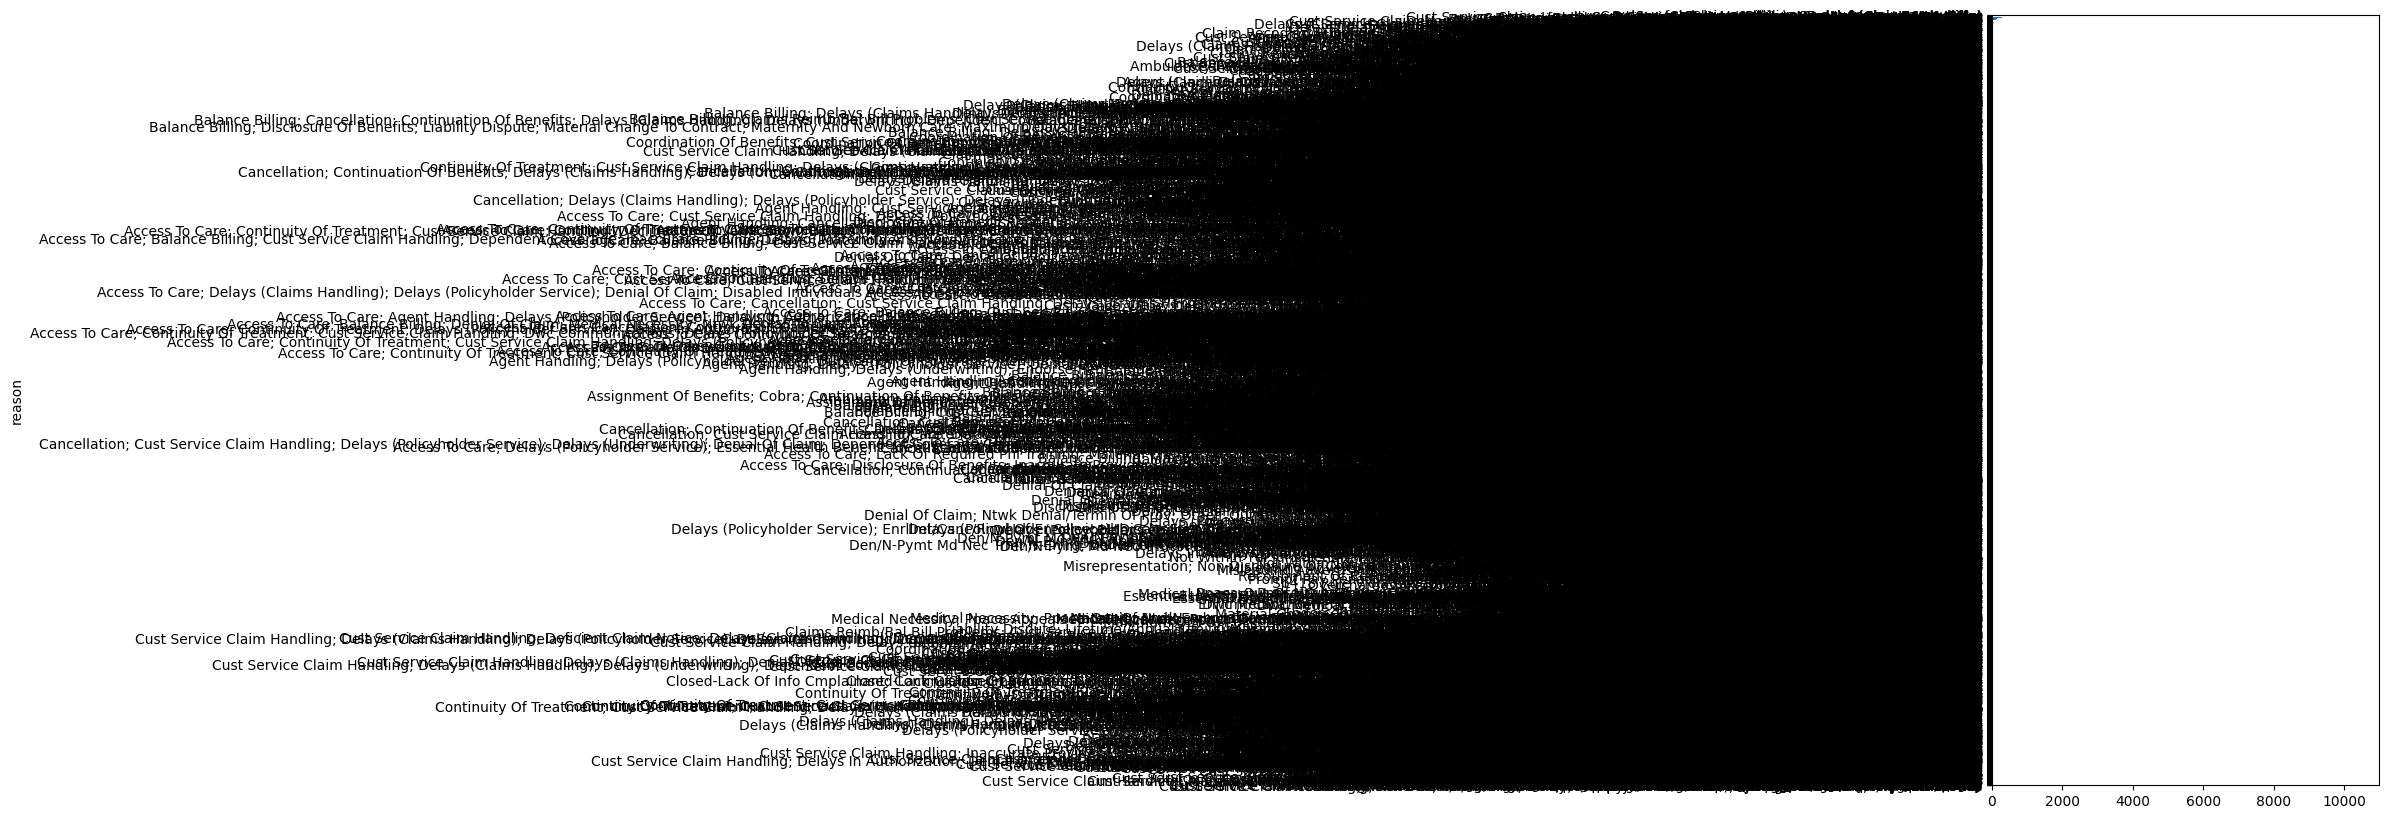

In [31]:
plt.figure(figsize=(5,10))
df.groupby('reason')['status'].sum().sort_values(ascending=True).plot.barh();

16) Scatter plot by 'Duration', 'Recovery'(Log) and 'Reason'

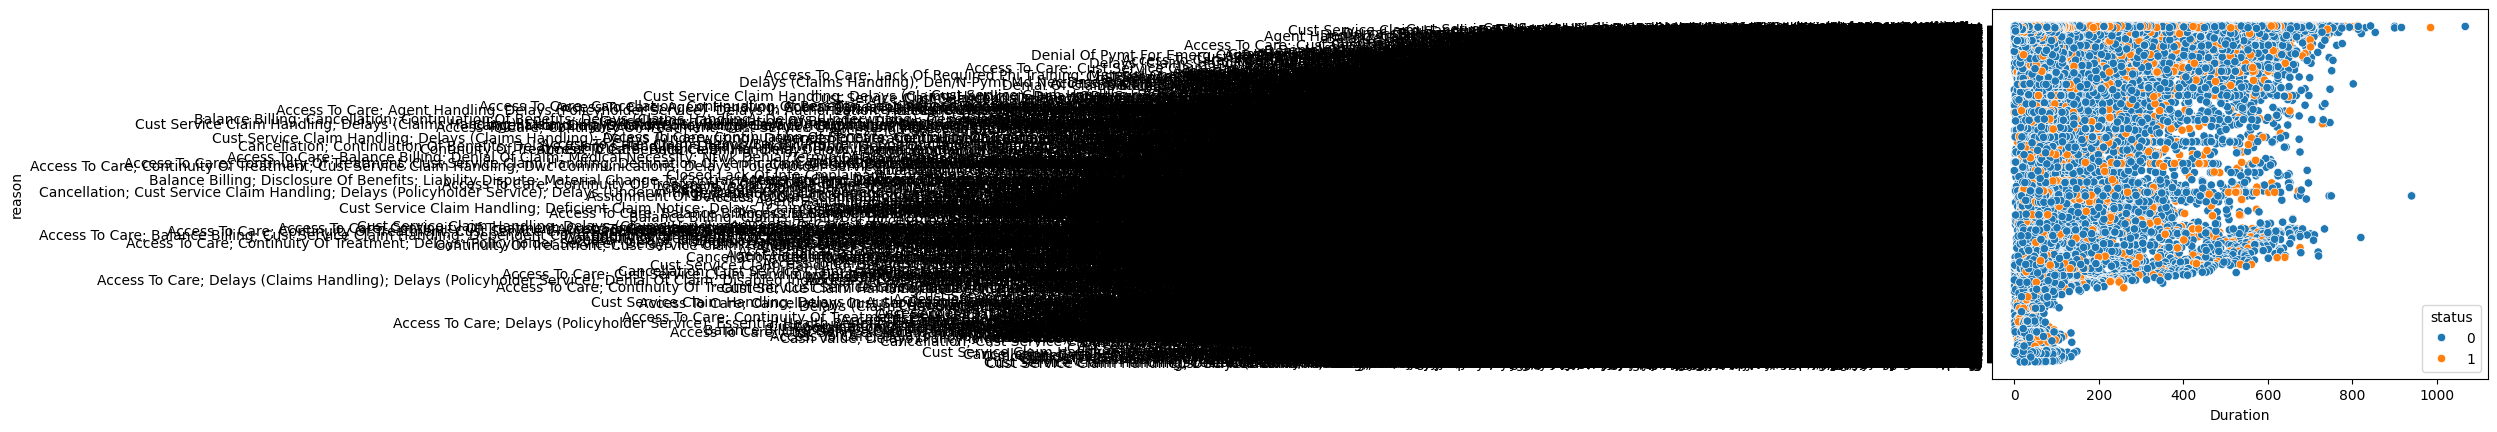

In [32]:
sns.scatterplot(data=df,x='Duration',y='reason',hue='status');

1) Rare Label Encoder

In [33]:
from feature_engine.encoding import RareLabelEncoder

1)-1 'Company' convert 3% or less to 'Others'

In [34]:
freq1=df['respondent_name'].value_counts(normalize=True)
print(freq1)

respondent_name
Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation    0.108503
Unitedhealthcare Insurance Company                                                    0.078279
Aetna Life Insurance Company                                                          0.051856
United Healthcare Services, Inc.                                                      0.026445
Progressive County Mutual Insurance Company                                           0.026034
                                                                                        ...   
Chesmar Homes, Ltd                                                                    0.000006
Bordman, Kenneth A                                                                    0.000006
Vergara, Maria D                                                                      0.000006
Chavez, Ninfa                                                                         0.000006
Roman, Michael                    

In [35]:
freq1_cat=[x for x in freq1.loc[freq1 >0.03].index.values]

In [36]:
print(freq1_cat)

['Blue Cross And Blue Shield Of Texas, A Division Of Health Care Service Corporation', 'Unitedhealthcare Insurance Company', 'Aetna Life Insurance Company']


In [37]:
df['respondent_name']=np.where(
    df['respondent_name'].isin(freq1_cat),
    df['respondent_name'], 'Others'
)

1)-2 'Coverage' convert 3% or less to 'Others'

In [38]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [39]:
freq2=df['coverage_type'].value_counts(normalize=True)
print(freq2)

coverage_type
Accident And Health         0.487503
Automobile                  0.283330
Homeowners                  0.129090
Life & Annuity              0.053451
Miscellaneous               0.029202
Liability                   0.009376
Fire, Allied Lines & Cmp    0.008048
Name: proportion, dtype: float64


In [40]:
freq2_cat=[x for x in freq2.loc[freq2 >0.03].index.values]

In [41]:

print(freq2_cat)

['Accident And Health', 'Automobile', 'Homeowners', 'Life & Annuity']


In [42]:
df['coverage_type']=np.where(
    df['coverage_type'].isin(freq2_cat),
    df['coverage_type'], 'Others'
)

2) Convert coverage_level  5% or less to 'Others'

In [43]:
freq3=df['coverage_level'].value_counts(normalize=True)
print(freq3)

coverage_level
Group A&H                      0.337476
Individual Private Pass        0.261843
Individual A & H               0.149310
Homeowners                     0.116090
Individual Life                0.040023
                                 ...   
Federal Programs               0.000006
Xx-Commercial Multi-Peril      0.000006
Ocean Marine                   0.000006
In Home/Incidental Business    0.000006
Xx-Private Passenger Group     0.000006
Name: proportion, Length: 65, dtype: float64


In [44]:
freq3_cat=[x for x in freq3.loc[freq3 >0.05].index.values]

In [45]:
print(freq3_cat)

['Group A&H', 'Individual Private Pass', 'Individual A & H', 'Homeowners']


In [46]:
df['coverage_level']=np.where(
    df['coverage_level'].isin(freq3_cat),
    df['coverage_level'], 'Others'
)

'Disposition' convert 3% or less to 'Others'

In [47]:
freq4=df['disposition'].value_counts(normalize=True)
print(freq4)

disposition
Contract Language/Legal Issue                                             0.142829
No Jurisdiction                                                           0.130796
Information Furnished; Contract Language/Legal Issue                      0.045559
Contract Language/Legal Issue; Information Furnished                      0.044208
Claim Settled                                                             0.032008
                                                                            ...   
Overpaid Claim Recouped; Claim Settled; Contract Language/Legal Issue     0.000006
Insufficient Information; Information Furnished; Record Only              0.000006
Referred To; Contract Language/Legal Issue; Additional Monies Received    0.000006
Company Position Upheld; Claim Settled; Complainant Retained Attorney     0.000006
Information Furnished; Non-Renewal Rescinded; Company Position Upheld     0.000006
Name: proportion, Length: 2706, dtype: float64


In [48]:
freq4_cat=[x for x in freq4.loc[freq4 >0.03].index.values]

In [49]:
print(freq4_cat)

['Contract Language/Legal Issue', 'No Jurisdiction', 'Information Furnished; Contract Language/Legal Issue', 'Contract Language/Legal Issue; Information Furnished', 'Claim Settled']


In [50]:
df['disposition']=np.where(
    df['disposition'].isin(freq4_cat),
    df['disposition'], 'Others'
)

In [51]:
df.head()

,complaint_number,respondent_name,complainant_role,reason,complaint_confirmed_code,disposition,received_date,closed_date,complaint_type,coverage_type,...,keyword,Open_Year,Open_Month,Open_Day,Close_Year,Close_Month,Close_Day,Duration,verdict_passed,status
4,5,Others,Insured,Unsatisfactory Settle/Offer,No,Others,2012-06-13,2012-07-17,Property And Casualty,Automobile,...,2012 North Texas Tornadoes; Adjuster'S Handlin...,2012,6,13,2012,7,17,34,No,0
5,6,Others,Insured,Cash Value; Misrepresentation,No,No Jurisdiction,2012-06-18,2012-07-30,"Life, Accident And Health",Life & Annuity,...,NaN,2012,6,18,2012,7,30,42,No,0
6,7,Others,Third Party,Unsatisfactory Settle/Offer,No,Others,2012-02-27,2012-07-02,Property And Casualty,Automobile,...,Claim Evaluation,2012,2,27,2012,7,2,126,Yes,1
7,8,"Blue Cross And Blue Shield Of Texas, A Divisio...",Insured,Denial Of Claim,No,Others,2012-06-19,2012-08-06,"Life, Accident And Health",Accident And Health,...,NaN,2012,6,19,2012,8,6,48,No,0
11,12,Others,Relative,Denial Of Claim,No,Contract Language/Legal Issue,2012-06-18,2012-07-19,"Life, Accident And Health",Accident And Health,...,NaN,2012,6,18,2012,7,19,31,No,0


 'Keyword' convert 3% or less to 'Others', convert missing to others

In [52]:
freq5=df['keyword'].value_counts(normalize=True)
print(freq5)

keyword
Claim Evaluation                                                                           0.215812
Claim Evaluation; Med Provider/Thirdparty Biller                                           0.066284
Adjuster'S Handling                                                                        0.063300
Underwriting Criteria                                                                      0.036250
Adjuster'S Handling; Claim Evaluation                                                      0.035644
                                                                                             ...   
Adjuster'S Handling; Appraisal; Claim Evaluation; Engineer'S Report; Roof; Water Damage    0.000007
Adjuster'S Handling; Claim Evaluation; Engineer'S Report; Hail; Roof; Water Damage         0.000007
Adjuster'S Handling; Claim Evaluation; Coverage Dispute; Depreciation; Senior Citizen      0.000007
Acv; Adjuster'S Handling; Deductible; Hail; Roof; Total Loss                               0

In [53]:
freq5_cat=[x for x in freq5.loc[freq5 >0.03].index.values]

In [54]:
print(freq5_cat)

['Claim Evaluation', 'Claim Evaluation; Med Provider/Thirdparty Biller', "Adjuster'S Handling", 'Underwriting Criteria', "Adjuster'S Handling; Claim Evaluation", 'Claim Evaluation; Out-Of-Ntwk Prvdr Mediation Rq']


In [55]:
df['keyword'] = df['keyword'].fillna('Others')
df['keyword'] = np.where(
    df['keyword'].isin(freq5_cat),
    df['keyword'], 'Others'
)

### 2) WoE Encoder

In [56]:
from feature_engine.encoding import WoEEncoder

In [57]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [58]:
df=df.fillna({'respondent_name':'Others','coverage_type':'Others','coverage_level':'Others',
           'reason':'Others','keyword':'Others','disposition':'Others'})

In [59]:
variables=['respondent_name','coverage_type','coverage_level','reason','keyword','disposition']

In [60]:
woe_enc=WoEEncoder(variables=variables)

In [61]:
df.columns

Index(['complaint_number', 'respondent_name', 'complainant_role', 'reason',
       'complaint_confirmed_code', 'disposition', 'received_date',
       'closed_date', 'complaint_type', 'coverage_type', 'coverage_level',
       'respondent_id', 'respondent_role', 'respondent_type',
       'complainant_type', 'involved_party_type', 'keyword', 'Open_Year',
       'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day',
       'Duration', 'verdict_passed', 'status'],
      dtype='object')

In [62]:
# find NaN in X
df.isnull().sum()

complaint_number                0
respondent_name                 0
complainant_role                0
reason                          0
complaint_confirmed_code        5
disposition                     0
received_date                   0
closed_date                     0
complaint_type                  1
coverage_type                   0
coverage_level                  0
respondent_id                   0
respondent_role                 0
respondent_type                 0
complainant_type                0
involved_party_type         18256
keyword                         0
Open_Year                       0
Open_Month                      0
Open_Day                        0
Close_Year                      0
Close_Month                     0
Close_Day                       0
Duration                        0
verdict_passed                  0
status                          0
dtype: int64

In [63]:
# drop rows with NaN in X
df = df.dropna()

In [112]:
X=df.drop(['Duration','status','complaint_number','received_date','closed_date','disposition',
           'Open_Year', 'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day', 'verdict_passed',
           'respondent_id'],axis=1)
y=df['status']

In [103]:
X

,respondent_name,complainant_role,reason,complaint_confirmed_code,complaint_type,coverage_type,coverage_level,respondent_role,respondent_type,complainant_type,involved_party_type,keyword
6,2,29,5722,0,11,1,3,19,1,0,4983,2
11,2,25,4503,0,6,0,2,19,1,0,4877,5
12,2,16,1439,0,11,1,3,19,1,0,1620,5
17,2,29,3720,0,11,1,3,19,1,0,1293,5
27,2,29,5722,0,11,1,3,19,1,0,1620,5
...,...,...,...,...,...,...,...,...,...,...,...,...
259583,2,29,2860,0,11,1,3,19,1,0,5582,0
259584,2,30,4503,0,6,0,2,34,1,1,5216,5
259585,2,24,2831,0,6,0,0,19,1,1,4608,5
259588,2,16,5583,0,11,2,1,19,1,0,3827,5


In [66]:
import pandas as pd
from feature_engine.encoding import WoEEncoder

# Combine rare categories into a single category
def combine_rare_categories(df, column, threshold=0.01):
    freq = df[column].value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    return df

# Apply the function to the 'reason' and 'disposition' columns

problematic_columns = ['complainant_role','reason', 'complaint_type', 'respondent_role', 'involved_party_type']
for col in problematic_columns:
    X = combine_rare_categories(X, col)
# X = combine_rare_categories(X, 'reason')
# X = combine_rare_categories(X, 'disposition')



In [67]:
# Initialize the WoEEncoder
woe_enc = WoEEncoder()

# Fit the WoEEncoder
woe_enc.fit(X, y)

WoEEncoder()

## Modeling

1) Get Dummies

In [113]:
X=pd.get_dummies(X)

In [114]:
X

,respondent_name,complainant_role,reason,complaint_confirmed_code,complaint_type,coverage_type,coverage_level,respondent_role,respondent_type,complainant_type,involved_party_type,keyword
6,2,29,5722,0,11,1,3,19,1,0,4983,2
11,2,25,4503,0,6,0,2,19,1,0,4877,5
12,2,16,1439,0,11,1,3,19,1,0,1620,5
17,2,29,3720,0,11,1,3,19,1,0,1293,5
27,2,29,5722,0,11,1,3,19,1,0,1620,5
...,...,...,...,...,...,...,...,...,...,...,...,...
259583,2,29,2860,0,11,1,3,19,1,0,5582,0
259584,2,30,4503,0,6,0,2,34,1,1,5216,5
259585,2,24,2831,0,6,0,0,19,1,1,4608,5
259588,2,16,5583,0,11,2,1,19,1,0,3827,5


### Set Logistic Regression as the baseline model

In [70]:


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=500)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")

--------------------
Accuracy: 0.8018722035505886
--------------------
Confusion Matrix:
[[29405  3643]
 [ 5966  9485]]
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     33048
           1       0.72      0.61      0.66     15451

    accuracy                           0.80     48499
   macro avg       0.78      0.75      0.76     48499
weighted avg       0.80      0.80      0.80     48499

--------------------


In [ ]:
cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Not Closed', 'Closed'], 
                                 index=['Not Closed', 'Closed'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

2) Split Train and Test

In [115]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [72]:
from sklearn.model_selection import StratifiedKFold

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# Get the cross-validation scores
scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean cross-validation score
print("Mean cross-validation score:", scores.mean())

# Get the test accuracy
test_accuracy = model.score(X_test, y_test)
print("Test accuracy:", test_accuracy)

# Get the validation accuracy
val_accuracy = model.score(X_val, y_val)
print("Validation accuracy:", val_accuracy)

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.001]

# filter out the non important features
important_features = X.columns[important_indices]

important_features


Cross-validation scores: [0.80199457 0.8011109  0.80350944 0.79857341 0.79838404]
Mean cross-validation score: 0.8007144727318674
Test accuracy: 0.8049444318439556
Validation accuracy: 0.8028807917758991


Index(['complaint_confirmed_code_Yes', 'complaint_confirmed_code_No',
       'reason_Other', 'reason_Denial Of Claim',
       'reason_Cust Service Claim Handling; Delays (Claims Handling)',
       'reason_Delays (Claims Handling)', 'coverage_type_Automobile',
       'complainant_role_Third Party',
       'coverage_level_Individual Private Pass',
       'complaint_type_Life, Accident And Health',
       'respondent_role_Ins Co - Licensed/Active', 'involved_party_type_Other',
       'reason_Balance Billing; Unsatisfactory Settle/Offer', 'keyword_Others',
       'complainant_role_Insured', 'keyword_Claim Evaluation',
       'respondent_role_Self-Funded / Erisa',
       'reason_Unsatisfactory Settle/Offer',
       'complaint_type_Property And Casualty',
       'reason_Delays (Claims Handling); Unsatisfactory Settle/Offer',
       'keyword_Claim Evaluation; Out-Of-Ntwk Prvdr Mediation Rq',
       'complainant_role_Other',
       'respondent_name_Unitedhealthcare Insurance Company',
       '

In [74]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("--------------------")
print(f'Accuracy: {accuracy}')
print("--------------------")
print('Confusion Matrix:')
print(conf_matrix)
print("--------------------")
print('Classification Report:')
print(class_report)
print("--------------------")


--------------------
Accuracy: 0.8018722035505886
--------------------
Confusion Matrix:
[[29405  3643]
 [ 5966  9485]]
--------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86     33048
           1       0.72      0.61      0.66     15451

    accuracy                           0.80     48499
   macro avg       0.78      0.75      0.76     48499
weighted avg       0.80      0.80      0.80     48499

--------------------


In [ ]:
cm_matrix = pd.DataFrame(data=conf_matrix, columns=['Not Closed', 'Closed'], 
                                 index=['Not Closed', 'Closed'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

Feature ranking:
complaint_confirmed_code_Yes: 0.13926060915857774
complaint_confirmed_code_No: 0.1269693984317015
reason_Other: 0.040821255528600615
reason_Denial Of Claim: 0.03203614024024112
reason_Cust Service Claim Handling; Delays (Claims Handling): 0.031263996502996515
reason_Delays (Claims Handling): 0.03058443443735019
coverage_type_Automobile: 0.026597287543477285
complainant_role_Third Party: 0.02330154023915897
coverage_level_Individual Private Pass: 0.022365776000165535
complaint_type_Life, Accident And Health: 0.02145452823875577
respondent_role_Ins Co - Licensed/Active: 0.020250308181381453
involved_party_type_Other: 0.019096528207879847
reason_Balance Billing; Unsatisfactory Settle/Offer: 0.0171501556682982
keyword_Others: 0.01648079910292096
complainant_role_Insured: 0.015218729870588006
keyword_Claim Evaluation: 0.014696258725680669
respondent_role_Self-Funded / Erisa: 0.014286079811756107
reason_Unsatisfactory Settle/Offer: 0.0126960940670387
complaint_type_Property 

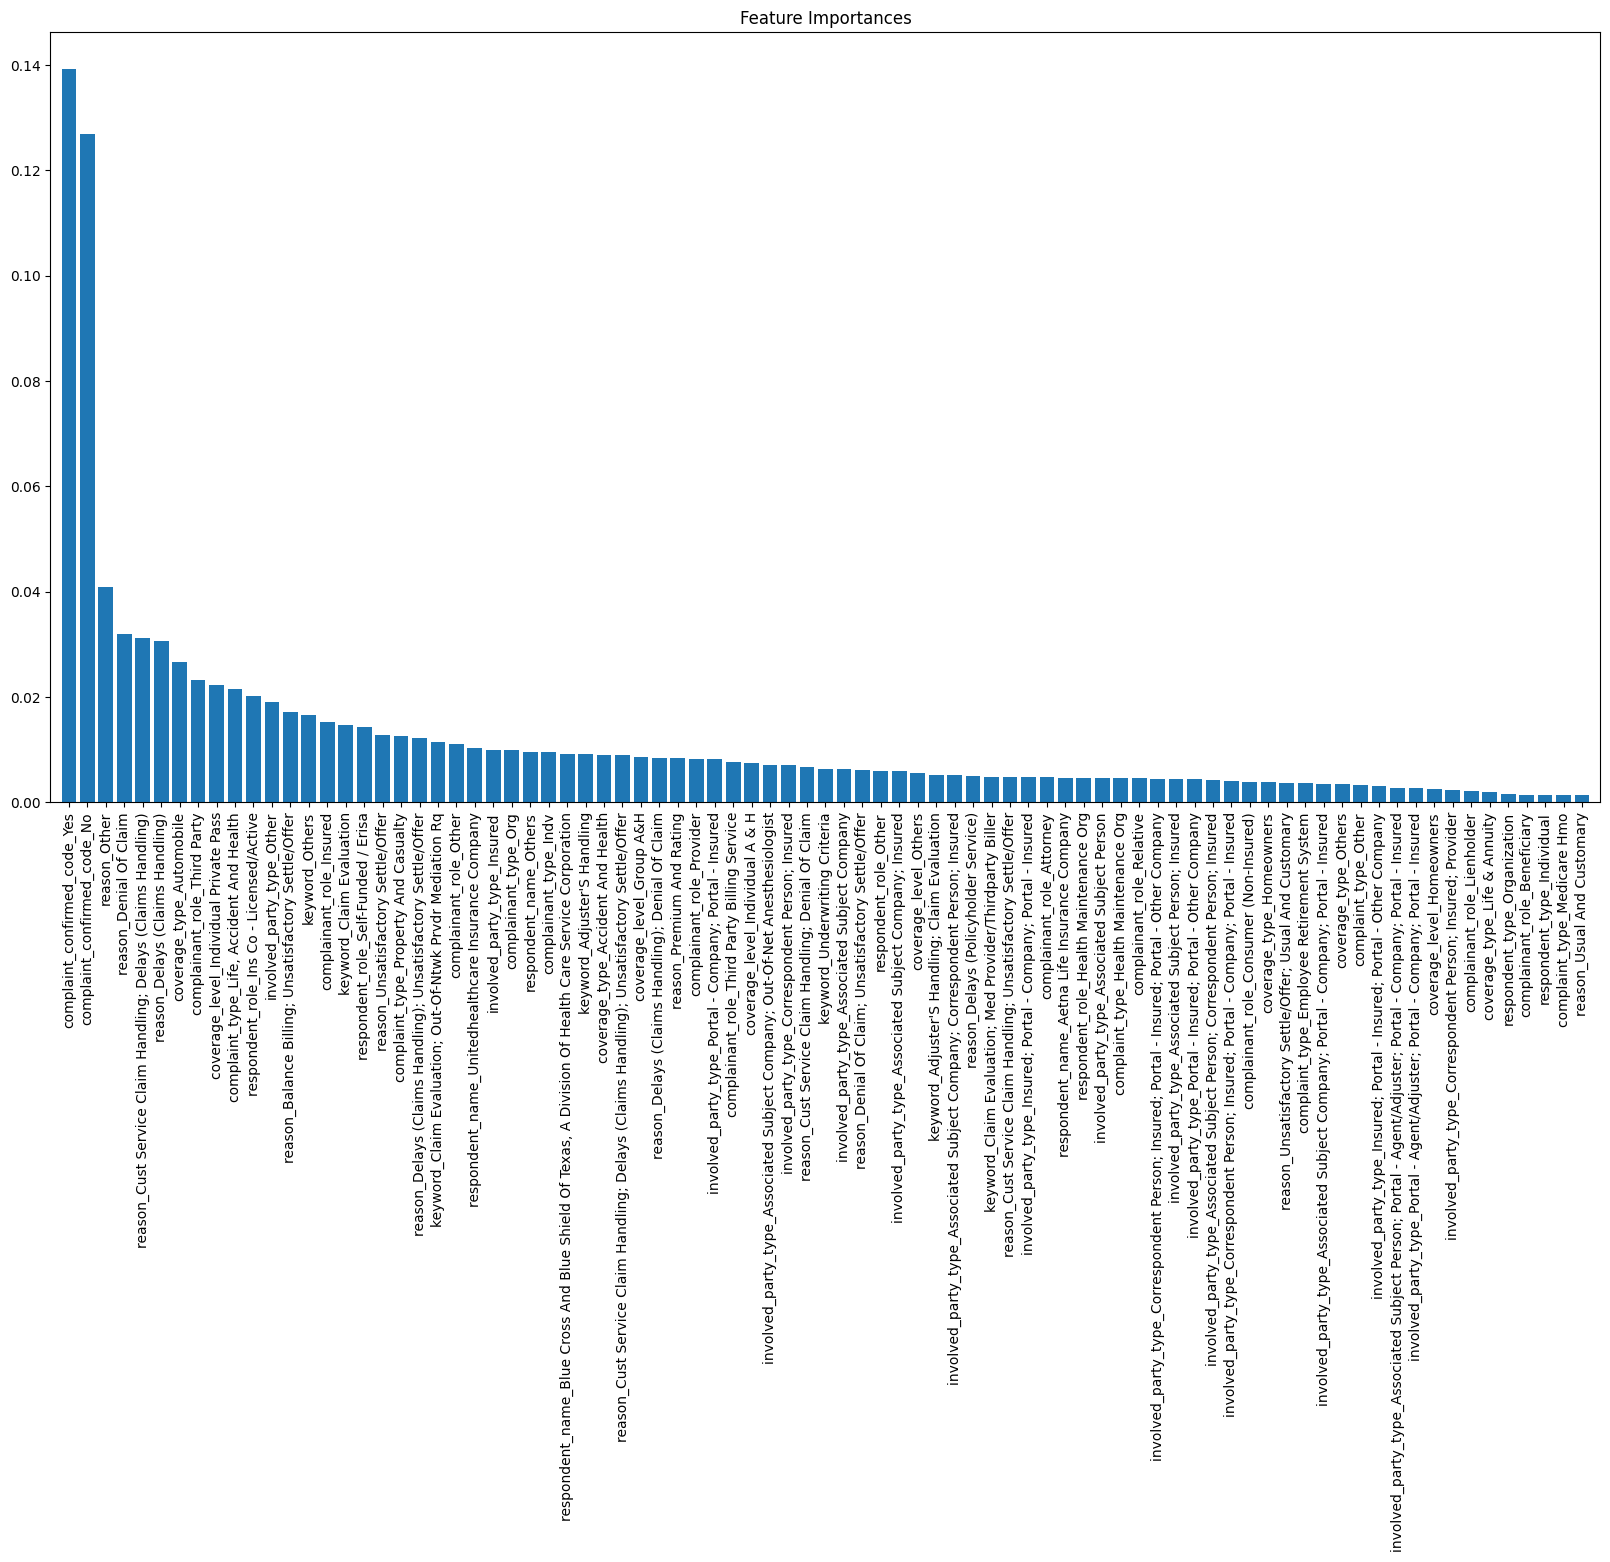

In [75]:
import matplotlib.pyplot as plt

# Get the feature importances
importances = model.feature_importances_

# Get the indices of the features sorted by importance
indices = np.argsort(importances)[::-1]

# Get the indices of features whose importance is greater than 0.01
important_indices = [i for i in indices if importances[i] > 0.001]

# Filter out the non-important features
important_features = X.columns[important_indices]

# Print the feature ranking
print("Feature ranking:")
for i in important_indices:
    print(f"{X.columns[i]}: {importances[i]}")

# Plot the feature importances
plt.figure(figsize=(20, 10))
plt.title("Feature Importances")
plt.bar(range(len(important_indices)), importances[important_indices], align="center")
plt.xticks(range(len(important_indices)), X.columns[important_indices], rotation=90)
plt.xlim([-1, len(important_indices)])
plt.show()

### Suport Vector Machines

In [76]:

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# Initialize the SVM model
svm_model = LinearSVC()

# Fit the model on the training data
svm_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8006969215860121
Confusion Matrix:
[[29834  3214]
 [ 6452  8999]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     33048
           1       0.74      0.58      0.65     15451

    accuracy                           0.80     48499
   macro avg       0.78      0.74      0.76     48499
weighted avg       0.79      0.80      0.79     48499



## LGBMC 

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming df is your DataFrame and 'status' is your target variable

# Fill missing values
df = df.fillna('Others')

# Encode categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Define features and target variable
X=df.drop(['Duration','status','complaint_number','received_date','closed_date','disposition',
           'Open_Year', 'Open_Month', 'Open_Day', 'Close_Year', 'Close_Month', 'Close_Day', 'verdict_passed',
           'respondent_id'],axis=1)
y=df['status']

# Apply SMOTE to the data
smote = SMOTE(sampling_strategy='minority')
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X, y = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
model = LGBMClassifier()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print the accuracy score
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print the classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 76952, number of negative: 77050
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 154002, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499682 -> initscore=-0.001273
[LightGBM] [Info] Start training from score -0.001273
Accuracy Score:  0.8155055907396745

Confusion Matrix:
 [[26576  6376]
 [ 5801 27249]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81     32952
           1       0.81      0.82      0.82     33050

    accuracy                           0.82     66002
   macro avg       0.82      0.82      0.82     66002
weighted avg       0.82      0.82      0.82     66002



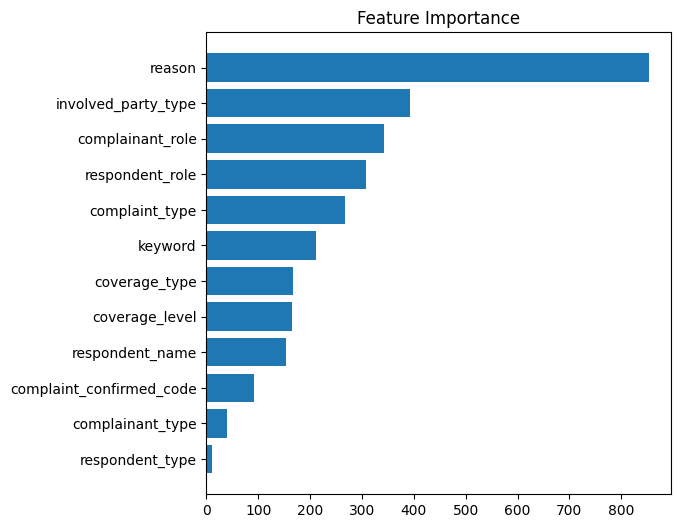

In [82]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

Cat Boost Classifier

In [87]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=200)
cat.fit(X_smote, y_smote)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

Learning rate set to 0.38733
0:	learn: 0.5888654	total: 159ms	remaining: 31.6s
1:	learn: 0.5496497	total: 168ms	remaining: 16.6s
2:	learn: 0.5277035	total: 177ms	remaining: 11.6s
3:	learn: 0.5160977	total: 186ms	remaining: 9.12s
4:	learn: 0.5059812	total: 197ms	remaining: 7.67s
5:	learn: 0.4976549	total: 206ms	remaining: 6.67s
6:	learn: 0.4912763	total: 217ms	remaining: 5.97s
7:	learn: 0.4855722	total: 228ms	remaining: 5.46s
8:	learn: 0.4804693	total: 238ms	remaining: 5.05s
9:	learn: 0.4761261	total: 247ms	remaining: 4.7s
10:	learn: 0.4724661	total: 257ms	remaining: 4.41s
11:	learn: 0.4693967	total: 267ms	remaining: 4.19s
12:	learn: 0.4668047	total: 278ms	remaining: 4s
13:	learn: 0.4655208	total: 288ms	remaining: 3.82s
14:	learn: 0.4638767	total: 296ms	remaining: 3.65s
15:	learn: 0.4621492	total: 306ms	remaining: 3.52s
16:	learn: 0.4513408	total: 316ms	remaining: 3.4s
17:	learn: 0.4473662	total: 326ms	remaining: 3.3s
18:	learn: 0.4462672	total: 336ms	remaining: 3.2s
19:	learn: 0.445033

In [88]:
print(f"Accuracy Score of Cat Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Cat Boost Classifier is : 0.8226720402412048
Confusion Matrix : 
[[26754  6198]
 [ 5506 27544]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     32952
           1       0.82      0.83      0.82     33050

    accuracy                           0.82     66002
   macro avg       0.82      0.82      0.82     66002
weighted avg       0.82      0.82      0.82     66002



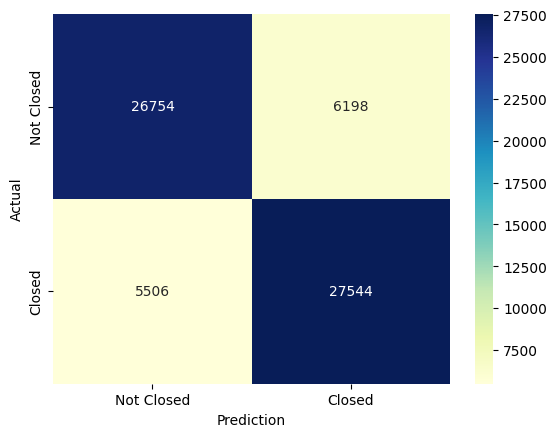

In [89]:
cm_matrix = pd.DataFrame(data=conf, columns=['Not Closed', 'Closed'], 
                                 index=['Not Closed', 'Closed'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10);

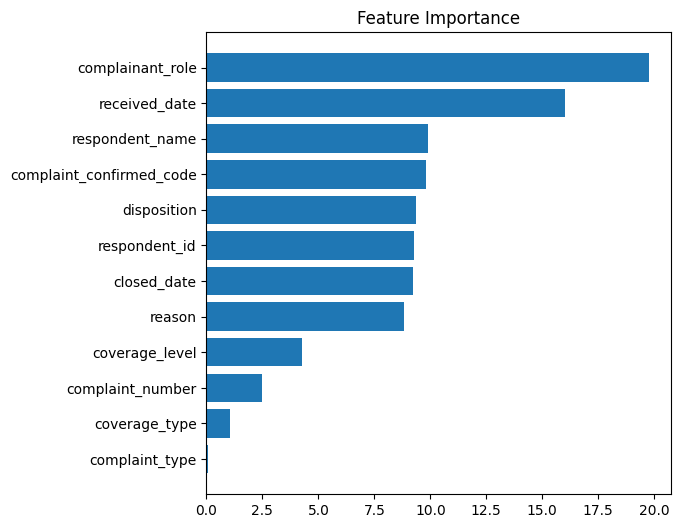

In [94]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113162 entries, 35971 to 200513
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   complaint_number          113162 non-null  int32         
 1   respondent_name           113162 non-null  int32         
 2   complainant_role          113162 non-null  int32         
 3   reason                    113162 non-null  int32         
 4   complaint_confirmed_code  113162 non-null  int32         
 5   disposition               113162 non-null  int32         
 6   received_date             113162 non-null  datetime64[ns]
 7   closed_date               113162 non-null  datetime64[ns]
 8   complaint_type            113162 non-null  int32         
 9   coverage_type             113162 non-null  int32         
 10  coverage_level            113162 non-null  int32         
 11  respondent_id             113162 non-null  int32         
 12  res

In [116]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79213 entries, 84981 to 137304
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   respondent_name           79213 non-null  int32
 1   complainant_role          79213 non-null  int32
 2   reason                    79213 non-null  int32
 3   complaint_confirmed_code  79213 non-null  int32
 4   complaint_type            79213 non-null  int32
 5   coverage_type             79213 non-null  int32
 6   coverage_level            79213 non-null  int32
 7   respondent_role           79213 non-null  int32
 8   respondent_type           79213 non-null  int32
 9   complainant_type          79213 non-null  int32
 10  involved_party_type       79213 non-null  int32
 11  keyword                   79213 non-null  int32
dtypes: int32(12)
memory usage: 4.2 MB


Epoch 1/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5892 - loss: 14.6977 - val_accuracy: 0.5468 - val_loss: 1.5589
Epoch 2/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.6065 - loss: 1.7458 - val_accuracy: 0.6845 - val_loss: 1.1013
Epoch 3/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step - accuracy: 0.6421 - loss: 0.9544 - val_accuracy: 0.6839 - val_loss: 1.5205
Epoch 4/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.6583 - loss: 0.7996 - val_accuracy: 0.7252 - val_loss: 0.5515
Epoch 5/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step - accuracy: 0.6801 - loss: 0.6841 - val_accuracy: 0.7008 - val_loss: 0.6789
Epoch 6/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.6831 - loss: 0.6605 - val_accuracy: 0.5068 - val_loss: 0.7809
Epoch 7/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.7024 - loss: 0.5961 - val_accuracy: 0.7264 - val_loss: 0.5627
Epoch 8/500
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0

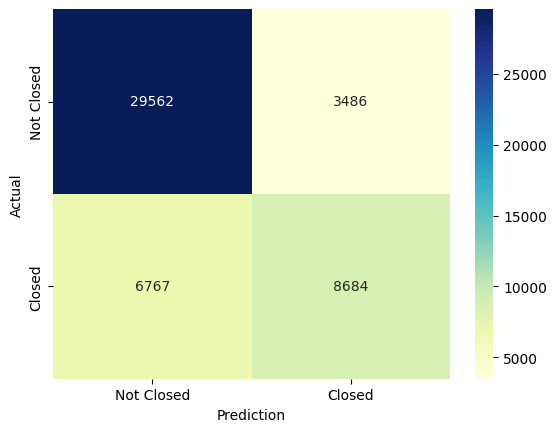

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers



# Define the model
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc}')

# Make predictions
y_pred = model.predict(X_test)

# Convert the predictions to binary
y_pred = (y_pred > 0.5).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

cm_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred), columns=['Not Closed', 'Closed'],
                            index=['Not Closed', 'Closed'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel("Prediction", fontsize=10)
plt.ylabel("Actual", fontsize=10)
plt.show()

